In [8]:
# import sys
# !{sys.executable} -m pip install textstat
import matplotlib.pyplot as plt
import textstat
import nltk
from random import randint
from collections import OrderedDict
import seaborn as sns
import numpy  as np
import pandas as pd
from pymer4.models import Lmer
import scipy.stats as stats 
from random import randint
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use('seaborn-v0_8')
#plt.style.use('ggplot')
import seaborn as sns
import math

## Data Collection

In [2]:
#add your path to the data folder
DATA_FOLDER = Path.home() / "Documents" / "Projects" / "lmem_test" / "data"

summaReranker_summary = DATA_FOLDER / "summareranker"/ "scores_r1.pkl"
summaReranker_summary = pd.read_pickle(summaReranker_summary)

pegasus_finetuned_summary = DATA_FOLDER / "pegasus_finetuned"/ "scored_summaries_finetuned.pkl"
pegasus_finetuned_summary = pd.read_pickle(pegasus_finetuned_summary)

pegasus_notfinetuned_summary = DATA_FOLDER / "pegasus_large"/ "scored_summaries.pkl"
pegasus_notfinetuned_summary = pd.read_pickle(pegasus_notfinetuned_summary)

original_text = DATA_FOLDER / "original_text"/ "test_text.pkl"
original_text = pd.read_pickle(original_text)

labels = DATA_FOLDER / "gold_standard"/ "test_label.pkl"
labels = pd.read_pickle(labels)

In [3]:
#create a dictionary with original_text index, reranker summary and a corresponding Rouge 1 score
summaReranker = {}
for element in summaReranker_summary:
    for ind, summary in enumerate(labels):
        if element[1] == summary:
            summaReranker[ind] = [element[0], element[2]]
            
#sort the dictionary based on the original text order            
summaReranker = OrderedDict(sorted(summaReranker.items())) 

ranker_total_scores = [v[1] for x,v in summaReranker.items()]

In [4]:
basemodel_unfinetuned = {}
for ind, x in enumerate(pegasus_notfinetuned_summary):
    index_val = randint(0,len(x))
    value = x[1][index_val]
    summary = x[0][index_val]
    basemodel_unfinetuned[ind] = [summary, value]
    
pegasus_unfinetuned_scores = [v[1]/100 for k,v in basemodel_unfinetuned.items()]  

In [5]:
basemodel_finetuned = {}
for ind, x in enumerate(pegasus_finetuned_summary):
    index_val = randint(0,len(x))
    value = x[1][index_val]
    summary = x[0][index_val]
    basemodel_finetuned[ind] = [summary, value]
    
pegasus_reddit_scores = [v[1]/100 for k,v in basemodel_finetuned.items()]  

In [6]:
#number of words 
number_of_words = [len(nltk.word_tokenize(text)) for text in original_text]

#difficult words 
difficult_words = [textstat.difficult_words(text) for text in original_text]

#number of sentences
sentence_count = [textstat.sentence_count(text) for text in original_text]

#flesch_reading_ease
flesch_reading_ease = [textstat.flesch_reading_ease(text) for text in original_text]

In [7]:
f"Mean Rouge 1 score Summareranker: {np.mean(ranker_total_scores)} for finetuned pegasus model: {np.mean(pegasus_reddit_scores)}"

'Mean Rouge 1 score Summareranker: 0.2805817708415109 for finetuned pegasus model: 0.2450332997406428'

## Data Visualization

In [25]:
def get_df_to_plot(length, base, ranker):
    base_df = pd.DataFrame({"length": length, "score": base})
    base_df["type"] = "baseline finetuned"
    ranker_df = pd.DataFrame({"length": length, "score": ranker})
    ranker_df["type"] = "summaReranker"
    df_concat = pd.concat([ranker_df, base_df])  
    return df_concat

In [88]:
def jointplot(data, xlabel, ylabel, xlim=None, ylim=None):
    # todo marker border
    plot = sns.jointplot(data=data, x="length", y="score", hue="type", xlim=xlim, ylim=ylim, alpha=.25, joint_kws={'edgecolor':None})
    plot.set_axis_labels(xlabel, ylabel) #, fontsize=16)  
    plt.gca().legend().set_title('')  
    # to save
    # plot.figure.savefig("images/jointplot1.png", dpi=300) 
    
def plot_with_sns(data, xlabel, ylabel, xlim=None, ylim=None):
    plot = sns.lineplot(data=df_plot, x="length", y="score", hue="type")
    plot.set_xlabel(xlabel)  # ,fontsize=16)  
    plot.set_ylabel(ylabel)
    plot.set_xlim(xlim)
    plot.set_ylim(ylim)
    plt.gca().legend().set_title('')
    # to save
    plot.figure.savefig("lineplot.png", dpi=300)
    
def regplot_sidebyside(data, xlabel, ylabel, xlim=None, ylim=None):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(16, 6)) #, dpi=300)
    colors = sns.color_palette('deep')
    sns.regplot(data=data.loc[data["type"] == "summaReranker"], x="length", y="score", ax=ax1, line_kws={"color": colors[1]}, scatter_kws={"color": colors[1], "alpha":.15})
    sns.regplot(data=data.loc[data["type"] == "baseline finetuned"], x="length", y="score", ax=ax2, line_kws={"color": colors[0]}, scatter_kws={"color": colors[0], "alpha":.15})
    # set axes
    ax1.set_xlim(xlim), ax1.set_ylim(ylim)
    ax2.set_xlim(xlim), ax2.set_ylim(ylim)
    ax1.set_xlabel(xlabel), ax1.set_ylabel(ylabel)
    ax2.set_xlabel(xlabel), ax2.set_ylabel(ylabel)
    # set legend
    legend1 = ax1.legend(["summaReranker"])
    legend1.legendHandles[0].set_color(colors[0])
    legend1.legendHandles[0].set_alpha(1)
    legend2 = ax2.legend(["baseline finetuned"])
    legend2.legendHandles[0].set_color(colors[1])
    legend2.legendHandles[0].set_alpha(1)
    # to save
    # fig.savefig("images/regplot_sidebyside.png", dpi=300)    

In [27]:
sns.set_theme(style="darkgrid")

In [13]:
def sort_data(variable, baseline_scores, ranker_scores):
    
    length = len(variable)
    assert len(baseline_scores) == length, "Mismatch"
    assert len(ranker_scores) == length, "Mismatch"

    sorted_indicies = sorted(range(length), key=lambda i: variable[i])

    sorted_base = [baseline_scores[i] for i in sorted_indicies]
    sorted_ranker = [ranker_scores[i] for i in sorted_indicies]
    sorted_length = sorted(variable)

    assert [variable[i] for i in sorted_indicies] == sorted_length, "Mismatch"
    
    return sorted_base, sorted_ranker, sorted_length

def get_bins(entry, size):
    return [entry[i*size:(i+1)*size] for i in range(math.ceil(len(entry)/ size))]

In [21]:
#sort the data for better visualization
difficult_words_base, difficult_words_ranker, difficult_words_length = sort_data(difficult_words, pegasus_reddit_scores, ranker_total_scores)

readability_base, readability_ranker, readability_length = sort_data(flesch_reading_ease, pegasus_reddit_scores, ranker_total_scores)

sentcount_base, sentcount_ranker, sentcount_length = sort_data(sentence_count, pegasus_reddit_scores, ranker_total_scores)

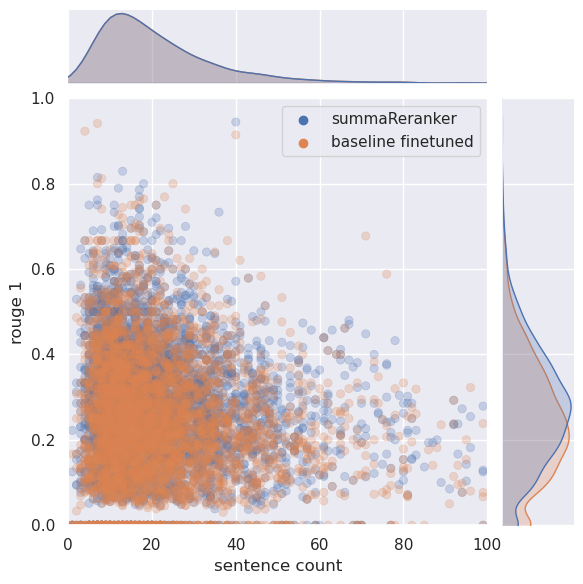

In [28]:
df_plot = get_df_to_plot(length=sentcount_length, base=sentcount_base, ranker=sentcount_ranker)
jointplot(data=df_plot, xlabel="sentence count", ylabel="rouge 1", xlim=[0,100], ylim=[0, 1])

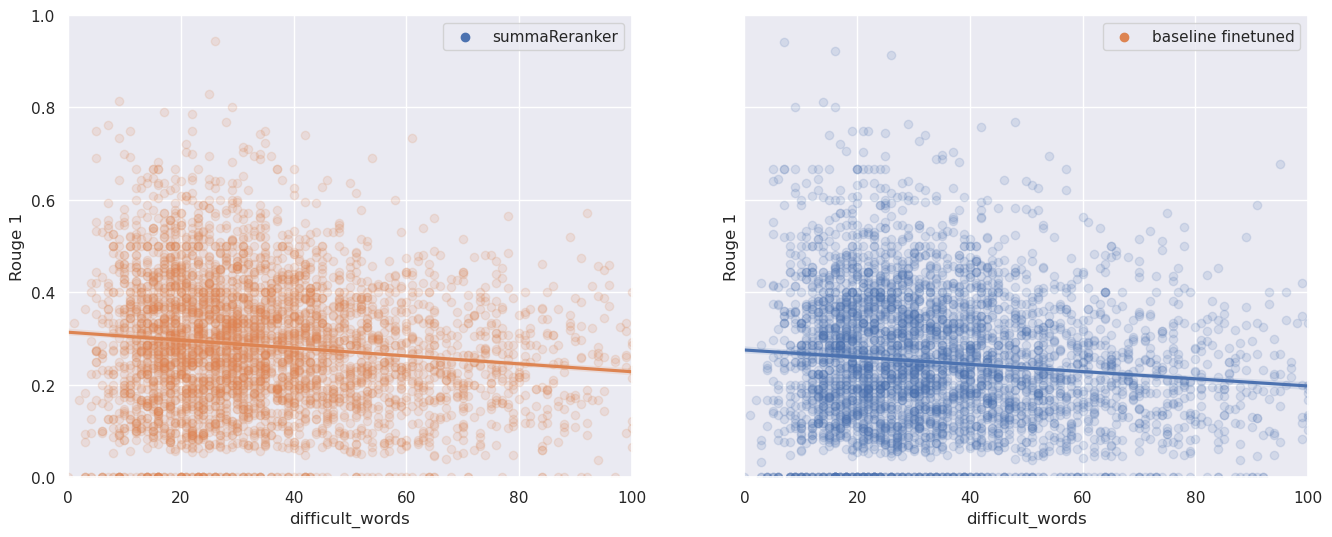

In [82]:
df_plot = get_df_to_plot(length=difficult_words_length, base=difficult_words_base, ranker=difficult_words_ranker)
regplot_sidebyside(data=df_plot, xlabel="difficult_words", ylabel="Rouge 1", xlim=[0,100], ylim=[0, 1])

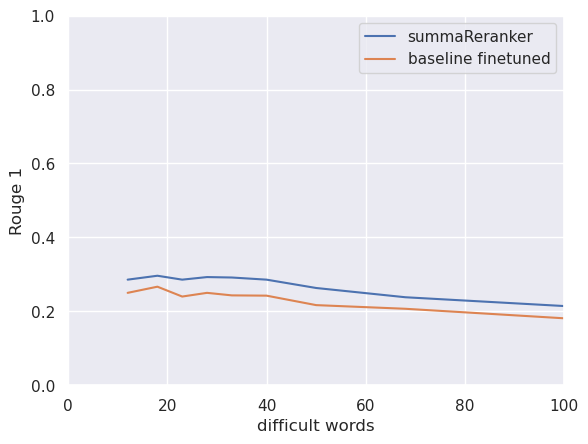

In [96]:
median_length = [np.median(b) for b in get_bins(difficult_words_length, 500)]
median_base = [np.median(b) for b in get_bins(difficult_words_base, 500)]
median_ranker = [np.median(b) for b in get_bins(difficult_words_ranker, 500)]

df_plot = get_df_to_plot(length=median_length, base=median_base, ranker=median_ranker)
plot_with_sns(data=df_plot, xlabel="difficult words", ylabel="Rouge 1", xlim=[0,100], ylim=[0, 1])

In [94]:
median_length = [np.median(b) for b in get_bins(readability_length, 500)]
median_base = [np.median(b) for b in get_bins(readability_base, 500)]
median_ranker = [np.median(b) for b in get_bins(readability_ranker, 500)]

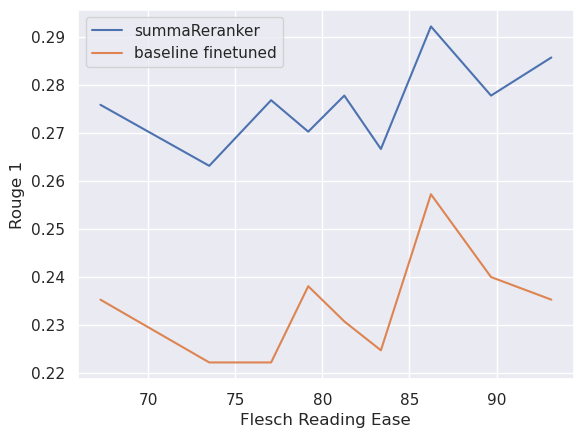

In [95]:
df_plot = get_df_to_plot(length=median_length, base=median_base, ranker=median_ranker)
plot_with_sns(data=df_plot, xlabel="Flesch Reading Ease", ylabel="Rouge 1")#, xlim=[0,100], ylim=[0, 1])

In [92]:
mean_length = [np.mean(b) for b in get_bins(readability_length, 500)]
mean_base = [np.mean(b) for b in get_bins(readability_base, 500)]
mean_ranker = [np.mean(b) for b in get_bins(readability_ranker, 500)]

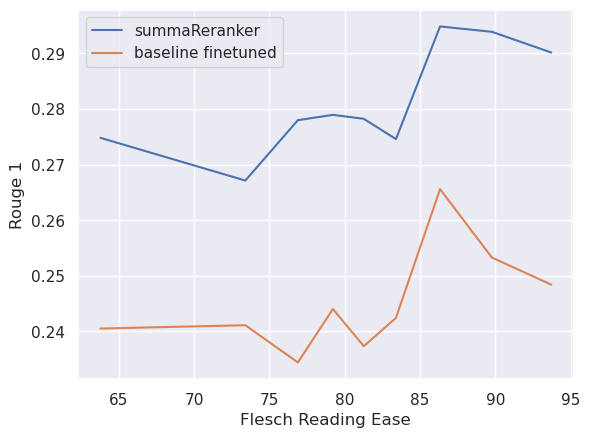

In [93]:
df_plot = get_df_to_plot(length=mean_length, base=mean_base, ranker=mean_ranker)
plot_with_sns(data=df_plot, xlabel="Flesch Reading Ease", ylabel="Rouge 1")#, xlim=[0,100], ylim=[0, 1])

## Evaluation Data Analysis - LMEMs

In [98]:
def GLRT(mod1, mod2):
    
    chi_square = 2 * abs(mod1.logLike - mod2.logLike)
    delta_params = abs(len(mod1.coefs) - len(mod2.coefs)) 
    
    return {"chi_square" : chi_square, "df": delta_params, "p" : 1 - stats.chi2.cdf(chi_square, df=delta_params)}

In [100]:
data = []
for i in range(len(pegasus_reddit_scores)):
    data.append({"id": str(i), "system":"baselineFinetuned", "score": pegasus_reddit_scores[i]})
    data.append({"id": str(i), "system":"summaReranker","score": ranker_total_scores[i]})

    
df = pd.DataFrame(data)
data = df.astype({"id" : 'category', "system" : 'category'})

differentMeans_model = Lmer(formula = "score ~ system + (1 | id)", data = data)
differentMeans_model.fit(factors = {"system" : ["baselineFinetuned", "summaReranker"]}, REML = False, summarize = False)

commonMean_model = Lmer(formula = "score ~ (1 | id)", data = data)
commonMean_model.fit(REML = False, summarize = False)

GLRT(differentMeans_model, commonMean_model)

{'chi_square': 385.65749773809875, 'df': 1, 'p': 0.0}